In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the pickled working dataset obtained from data_extraction.ipynb.

In [ ]:
def getfile(f, **kwargs):
  loc = 'https://drive.google.com/uc?export=download&id='+f.split('/')[-2]
  out = pd.read_pickle(loc, **kwargs)
  return out

# working dataset
f = "https://drive.google.com/file/d/1pltF9KHbAy4UPCin6W_qI317A6-xaCdT/view?usp=drive_link"
# debugging dataset
# f = "https://drive.google.com/file/d/1-6Pd1y-O0LzcpzSy1VPONV2ASD7WmAPS/view?usp=drive_link"
df = getfile(f)
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020


Convert DateTime objects to float values.

In [ ]:
df['Date'] = df['Date_Numeric'].dt.to_period('M')
df['Date'] = df['Date'].dt.to_timestamp().apply(lambda x : pd.Timestamp(x).to_julian_date())
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


Drop redundant columns.

In [ ]:
df.drop(['Year', 'Month', 'Date_Numeric'], axis='columns', inplace=True)
df.head()

,Area Name,Area Type,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


Convert categorical variables to numerical values. Drop one dummy variable in each category to prevent multicollinearity.

In [ ]:
categorical_cols = ['Area Name', 'Area Type', 'Seasonally Adjusted(Y/N)', 'Status', 'Benchmark']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,Labor Force,Employment,Unemployment,Unemployment Rate,Date,Area Name_Adelanto city,Area Name_Agoura Hills city,Area Name_Alameda County,Area Name_Alameda city,Area Name_Alamo CDP,...,Area Name_Yuba County,Area Name_Yucaipa city,Area Name_Yucca Valley town,Area Type_Metropolitan Area,Area Type_State,Area Type_Sub-County Place,Seasonally Adjusted(Y/N)_Y,Status_Preliminary,Benchmark_2021,Benchmark_2023
0,9672362,8668016,1004346,10.4,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,9774280,8875685,898595,9.2,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
2,9684440,8704564,979876,10.1,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,9768885,8871553,897332,9.2,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
4,9689626,8776344,913282,9.4,2442838.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df.shape

(204096, 1032)

In [ ]:
X = df.drop('Unemployment Rate', axis=1).values
y = df['Unemployment Rate'].values

#Scaling feature
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Prepare sequential data
timesteps = 1
X_seq = X.reshape((X.shape[0], timesteps, X.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([163276, 1, 1031])
X_test shape: torch.Size([40820, 1, 1031])
y_train shape: torch.Size([163276, 1])
y_test shape: torch.Size([40820, 1])


# Investigate effects of mini-batch learning

In [ ]:
# Build the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

In [ ]:
# Training
def train(model, trainloader, valloader, criterion, optimizer, epochs=100):
  history = {"train_loss": [], "val_loss": []}

  for epoch in range(epochs):
      model.train()
      train_loss = 0.0
      for inputs, labels in trainloader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      train_loss /= len(trainloader)
      history["train_loss"].append(train_loss)

      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in valloader:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()

      val_loss /= len(valloader)
      history["val_loss"].append(val_loss)

      if (epoch + 1) % 10 == 0:
          print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [ ]:
def eval(model, testloader):
  model.eval()
  mse_loss = 0.0
  mae_loss = 0.0
  r2 = 0.0
  with torch.no_grad():
    for inputs, labels in testloader:
      outputs = model(inputs)
      mse_loss += mean_squared_error(labels, outputs)
      mae_loss += mean_absolute_error(labels, outputs)
      r2 += r2_score(labels, outputs)

  return mse_loss / len(testloader), mae_loss / len(testloader), r2 / len(testloader)

In [ ]:
input_size = X_seq.shape[2]  # Number of features
hidden_size = 100  # Number of RNN units
output_size = 1  # Predicting a single value (unemployment rate)
num_layers = 2  # Number of RNN layers

In [ ]:
# Split into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([130620, 1, 1031])
X_test shape: torch.Size([40820, 1, 1031])
y_train shape: torch.Size([130620, 1])
y_test shape: torch.Size([40820, 1])


In [ ]:
mse_losses = []
mae_losses = []
r2_scores = []

In [ ]:
batch_sizes = [16, 32, 64, 128]
for batch_size in batch_sizes:
  print(f"\nBatch size: {batch_size}")
  trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  model = RNNModel(input_size, hidden_size, output_size, num_layers)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  train(model, trainloader, valloader, criterion, optimizer)
  mse_loss, mae_loss, r2 = eval(model, testloader)

  mse_losses.append(mse_loss)
  mae_losses.append(mae_loss)
  r2_scores.append(r2)
  print(f"MSE Loss: {mse_loss:.4f}, MAE Loss: {mae_loss:.4f}, R2 Score: {r2:.4f}")



Batch size: 16
Epoch [10/100], Train Loss: 8.0228, Val Loss: 8.1045
Epoch [20/100], Train Loss: 7.6586, Val Loss: 7.9244
Epoch [30/100], Train Loss: 7.7046, Val Loss: 7.9393
Epoch [40/100], Train Loss: 7.5705, Val Loss: 7.8188
Epoch [50/100], Train Loss: 7.6659, Val Loss: 7.9842
Epoch [60/100], Train Loss: 7.3532, Val Loss: 7.6977
Epoch [70/100], Train Loss: 7.5190, Val Loss: 7.7534
Epoch [80/100], Train Loss: 7.4993, Val Loss: 8.2696
Epoch [90/100], Train Loss: 7.4137, Val Loss: 7.6895
Epoch [100/100], Train Loss: 7.5103, Val Loss: 7.8450
MSE Loss: 7.7442, MAE Loss: 1.9042, R2 Score: 0.7637

Batch size: 32
Epoch [10/100], Train Loss: 7.3673, Val Loss: 7.3513
Epoch [20/100], Train Loss: 7.0617, Val Loss: 7.2019
Epoch [30/100], Train Loss: 7.0147, Val Loss: 7.8739
Epoch [40/100], Train Loss: 6.9888, Val Loss: 7.2828
Epoch [50/100], Train Loss: 6.8835, Val Loss: 7.4734
Epoch [60/100], Train Loss: 6.8654, Val Loss: 7.0315
Epoch [70/100], Train Loss: 6.7421, Val Loss: 7.1242
Epoch [80/100

In [ ]:
batch_sizes = [256, 512, 1024, 2048]
for batch_size in batch_sizes:
  print(f"\nBatch size: {batch_size}")
  trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  model = RNNModel(input_size, hidden_size, output_size)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  train(model, trainloader, valloader, criterion, optimizer)
  mse_loss, mae_loss, r2 = eval(model, testloader)

  mse_losses.append(mse_loss)
  mae_losses.append(mae_loss)
  r2_scores.append(r2)
  print(f"MSE Loss: {mse_loss:.4f}, MAE Loss: {mae_loss:.4f}, R2 Score: {r2:.4f}")

# Conclusions

The model performs better with larger batch sizes, as seen by the lower MSE/MAE loss and higher R2 score.

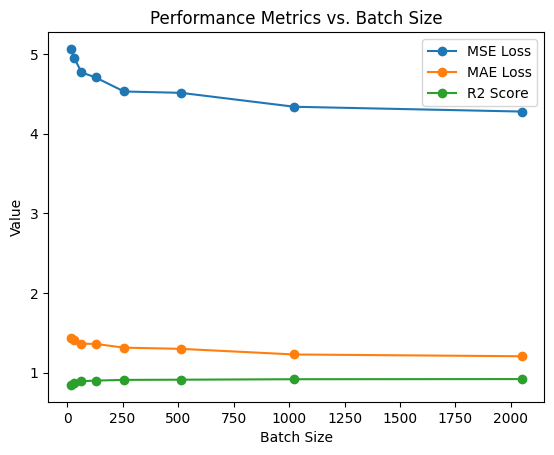

In [3]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]
# temp
mse_losses = [5.0613, 4.9513, 4.7676, 4.7039, 4.5274, 4.5107, 4.3358, 4.2757]
mae_losses = [1.4368, 1.4150, 1.3643, 1.3613, 1.3142, 1.2992, 1.2286, 1.2064]
r2_scores = [0.8468, 0.8763, 0.8932, 0.9013, 0.9100, 0.9123, 0.9182, 0.9202]

plt.plot(batch_sizes, mse_losses, label='MSE Loss', marker='o')
plt.plot(batch_sizes, mae_losses, label='MAE Loss', marker='o')
plt.plot(batch_sizes, r2_scores, label='R2 Score', marker='o')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Value')
plt.title('Performance Metrics vs. Batch Size')
plt.show()

debugging dataset results:

In [ ]:
# Batch size: 16
# Epoch [10/100], Train Loss: 14.8161, Val Loss: 18.7288
# Epoch [20/100], Train Loss: 9.2154, Val Loss: 14.9320
# Epoch [30/100], Train Loss: 8.4547, Val Loss: 14.3672
# Epoch [40/100], Train Loss: 7.1126, Val Loss: 14.1257
# Epoch [50/100], Train Loss: 6.4145, Val Loss: 13.5924
# Epoch [60/100], Train Loss: 6.3400, Val Loss: 14.5617
# Epoch [70/100], Train Loss: 6.4920, Val Loss: 14.5393
# Epoch [80/100], Train Loss: 5.9553, Val Loss: 14.2768
# Epoch [90/100], Train Loss: 5.8614, Val Loss: 14.5257
# Epoch [100/100], Train Loss: 5.6932, Val Loss: 14.3241
# MSE Loss: 13.7916, MAE Loss: 2.4647, R2 Score: 0.5652

# Batch size: 32
# Epoch [10/100], Train Loss: 17.2399, Val Loss: 20.2217
# Epoch [20/100], Train Loss: 10.5658, Val Loss: 18.4745
# Epoch [30/100], Train Loss: 8.7186, Val Loss: 17.1227
# Epoch [40/100], Train Loss: 7.1616, Val Loss: 16.5705
# Epoch [50/100], Train Loss: 6.8027, Val Loss: 15.7319
# Epoch [60/100], Train Loss: 6.5712, Val Loss: 14.4860
# Epoch [70/100], Train Loss: 6.2304, Val Loss: 15.2795
# Epoch [80/100], Train Loss: 6.0181, Val Loss: 14.8353
# Epoch [90/100], Train Loss: 5.6856, Val Loss: 14.9839
# Epoch [100/100], Train Loss: 5.5782, Val Loss: 14.7466
# MSE Loss: 12.3669, MAE Loss: 2.3996, R2 Score: 0.6821

# Batch size: 64
# Epoch [10/100], Train Loss: 16.6986, Val Loss: 23.2086
# Epoch [20/100], Train Loss: 11.0081, Val Loss: 20.6856
# Epoch [30/100], Train Loss: 8.5959, Val Loss: 17.4249
# Epoch [40/100], Train Loss: 7.3881, Val Loss: 17.3612
# Epoch [50/100], Train Loss: 6.7308, Val Loss: 17.5548
# Epoch [60/100], Train Loss: 6.3915, Val Loss: 16.2184
# Epoch [70/100], Train Loss: 6.1516, Val Loss: 14.6982
# Epoch [80/100], Train Loss: 6.0675, Val Loss: 14.5730
# Epoch [90/100], Train Loss: 5.6434, Val Loss: 13.9260
# Epoch [100/100], Train Loss: 5.6314, Val Loss: 14.0449
# MSE Loss: 12.6617, MAE Loss: 2.4116, R2 Score: 0.7172

# Batch size: 128
# Epoch [10/100], Train Loss: 17.6243, Val Loss: 20.0473
# Epoch [20/100], Train Loss: 11.3208, Val Loss: 17.4686
# Epoch [30/100], Train Loss: 8.4845, Val Loss: 17.4926
# Epoch [40/100], Train Loss: 7.0569, Val Loss: 16.3902
# Epoch [50/100], Train Loss: 6.3206, Val Loss: 15.9952
# Epoch [60/100], Train Loss: 5.9333, Val Loss: 15.0235
# Epoch [70/100], Train Loss: 5.6925, Val Loss: 15.4825
# Epoch [80/100], Train Loss: 5.4707, Val Loss: 15.1774
# Epoch [90/100], Train Loss: 5.4996, Val Loss: 15.0551
# Epoch [100/100], Train Loss: 5.0639, Val Loss: 14.7310
# MSE Loss: 12.3878, MAE Loss: 2.3256, R2 Score: 0.7457